# SOGOS Overview for MLGeo 2022
**Southern Ocean Glider Observations of the Submesoscale**

In this notebook we attempt to [write motivation]

There are three main sections

Estimation of high-resolution pH by Random Forest

Notes 2022.12.02
- Check project_overview.md in ml-geo git folder for detailed variable notes
- Data comes from two gliders (sg660 and sg659), GO-SHIP cruise bottle sampling, and BGC-Argo
- gp_660, gp_659 --> *G*ridded-on-*P*ressure_#ID of glider

- Yeardays approximately 120-210 (May to August 2019)

## 0. Import Packages and Data

In [7]:
# !pip install cmocean
# !pip install glidertools
# !pip install gsw

# if you update the new environment.yml file in ml-sogos, you will not have to run this
# (within the folder you can run) conda env update -f environment.yml

  Using cached cmocean-2.0-py3-none-any.whl (223 kB)
     |████████████████████████████████| 82 kB 695 kB/s eta 0:00:011
     |████████████████████████████████| 99 kB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 442 kB 16.1 MB/s eta 0:00:01
  Using cached seawater-3.3.4.tar.gz (22 kB)
     |████████████████████████████████| 46 kB 22.8 MB/s eta 0:00:01
     |████████████████████████████████| 157 kB 15.2 MB/s eta 0:00:01
  Created wheel for seawater: filename=seawater-3.3.4-py3-none-any.whl size=26452 sha256=3629511ebdef9d68026c599e30ee6ff1c4cda0584a7ef1d7dc62e92c703062db
  Stored in directory: /Users/sangminsong/Library/Caches/pip/wheels/ca/e5/4a/d04154df148b68a585471323bf5398366f93a994a384acbe9d
Successfully built seawater


In [1]:
# Import packages 
import xarray as xr
import pandas as pd
import numpy as np
import gsw 
import matplotlib.pyplot as plt
from cmocean import cm as cmo
from datetime import datetime
import scipy
import glidertools as gt
import importlib
import seaborn as sns

import sogos_module as sg  # our custom module
# from sogos_module import lims, palettes

In [2]:
# Machine Learning/Statistics Packages
from scipy.stats import kde
from scipy.stats import iqr
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score


In [4]:
# Set up directories and import main dataframes
data_path = '../data/'
var_path = '../gridded-vars/'

# Import ship/float merged data to train the model 
total_DF = pd.read_csv(var_path + 'Merged_ShipFloat_DF_1202.csv', index_col=[0])

# Import glider data to run ML prediction on
df_659 = pd.read_csv(var_path + 'Glider659_DF_1202.csv', index_col=[0])  # flattened 2d array
df_660 = pd.read_csv(var_path + 'Glider660_DF_1202.csv', index_col=[0])

gp_659 = xr.open_dataset(data_path + 'gp_659_forMLGeo1026.nc') # pressure-gridded dataset
gp_660 = xr.open_dataset(data_path + 'gp_660_forMLGeo1026.nc')

# Original data files for ship and float before merging:
# float_directory = data_path + 'float/'
# ship_filepath =  data_path + 'bottle_data.csv'

# Optional import satellite data for plotting
# fsle = xr.open_dataset(file_path + 'fsle_backwards.nc')
# adt = xr.open_dataset(file_path + 'satellite_data.nc')

---
# Random Forest pH Prediction

**Steps for RF Model Training:**

1. Check feature correlations
2. Split data into training/test/validation
3. Train the model on ship and float data
4. Perform prediction
4. Compare model performance



## 1. Variable distributions and correlations

Text(0.5, 1.0, 'Correlation Heatmap')

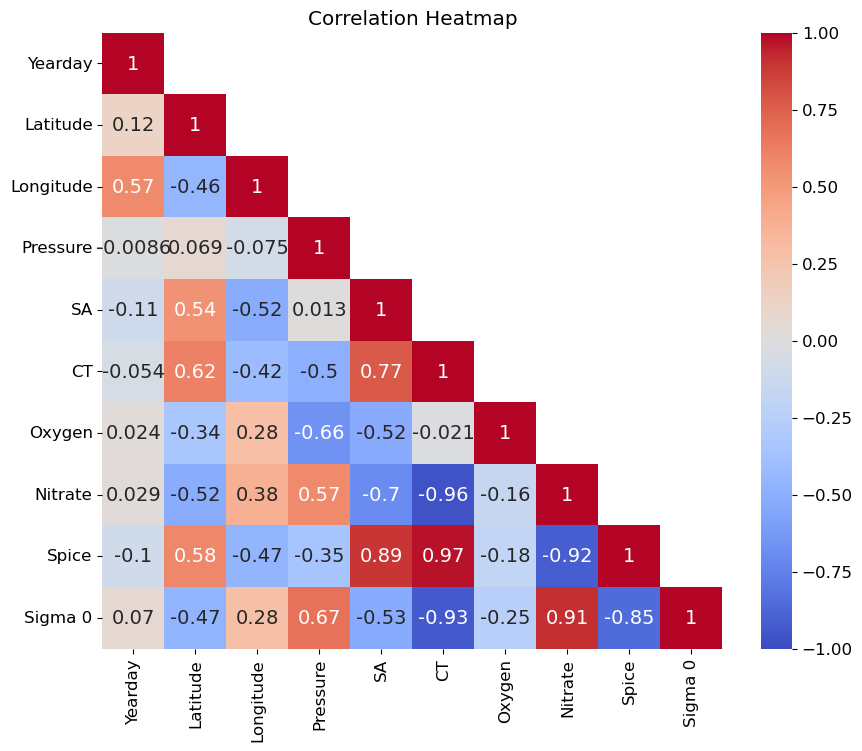

In [5]:
dfcorr = total_DF.drop({'pH', 'Julian Day', 'Sigma 1', 'Sigma 2'},axis=1).corr()
# plot a heatmap with annotation

plt.figure(figsize=(10,8))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(dfcorr, dtype=bool),k=1)
hm = sns.heatmap(dfcorr, mask=mask, annot=True, cmap='coolwarm', annot_kws={"size": 14}, center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

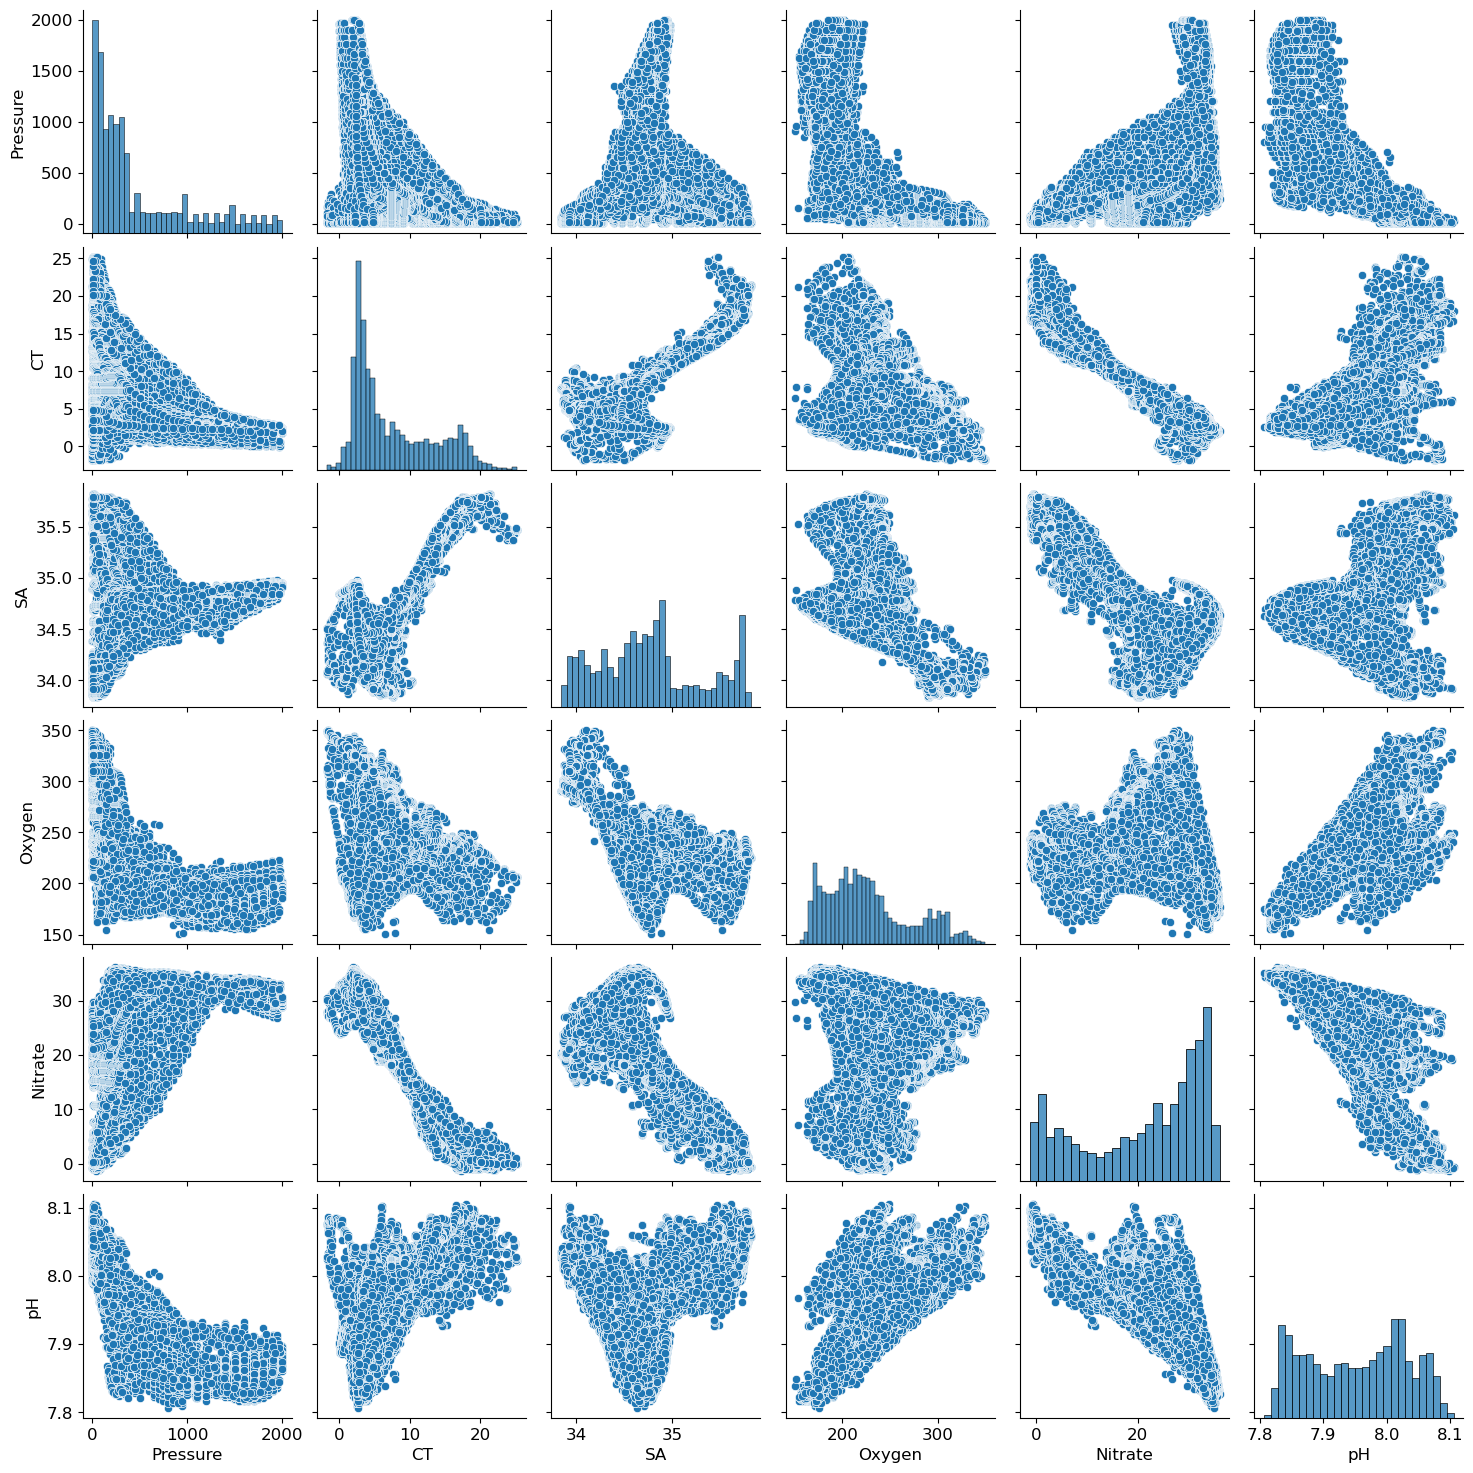

In [ ]:
# Pair Wise Plots
PWDF = total_DF[["Pressure", "CT", "SA", "Oxygen", "Nitrate", 'pH']]
sns.pairplot(PWDF)
# plt.savefig("PairPlot.png")
plt.show()

### Variable distributions

n, bins, patches = plt.hist(x=TrainingDF.SA.values, bins=1000, color='#0504aa', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title("Salinity")
plt.show()
n, bins, patches = plt.hist(x=TrainingDF.CT.values, bins=1000, color='#0504aa', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title("Temperature")
plt.show()
n, bins, patches = plt.hist(x=TrainingDF.Oxygen.values, bins=1000, color='#0504aa', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title("Oxygen")
plt.show()
n, bins, patches = plt.hist(x=TrainingDF.Nitrate.values, bins=1000, color='#0504aa', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title("Nitrate")
plt.show()
n, bins, patches = plt.hist(x=TrainingDF.pH.values, bins=1000, color='#0504aa', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title("pH")
plt.show()

## 2. Scale and split data

### 2.1 Feature Scaling

In [38]:
def scale_features(df):
    scaler = preprocessing.MinMaxScaler().fit(df.drop("Julian Day",axis=1))
    features = scaler.transform(df.drop("Julian Day",axis=1))
    feature_cols = df.drop("Julian Day",axis=1).columns
    return pd.DataFrame(features, columns=feature_cols)

In [39]:
scaled_DF = scale_features(total_DF)
scaled_DF.head()

,Yearday,Latitude,Longitude,Pressure,SA,CT,Oxygen,Nitrate,pH,Spice,Sigma 0,Sigma 1,Sigma 2
0,0.026586,0.949012,0.165058,0.001954,0.963034,0.853364,0.351513,0.019381,0.881308,0.848220,0.313164,0.290819,0.273184
1,0.026586,0.949012,0.165058,0.003958,0.963032,0.853335,0.351054,0.015298,0.878796,0.848185,0.313212,0.290864,0.273228
2,0.026586,0.949012,0.165058,0.005962,0.964039,0.853045,0.350520,0.015405,0.878563,0.848080,0.314053,0.291637,0.273947
3,0.026586,0.949012,0.165058,0.008968,0.968595,0.851657,0.348974,0.014863,0.872188,0.847513,0.317983,0.295251,0.277312
4,0.026586,0.949012,0.165058,0.010972,0.969102,0.850998,0.347439,0.014714,0.868493,0.846836,0.319283,0.296466,0.278460


### 2.2 Splitting Train/Test/Validation Data

In [ ]:
# archive: old import
# Use training_data.ipynb to create training datasets and save the training/test/validation datasets as .nc or .csv files
# Then, load the training data here

# file_path = "../data/"
# training = pd.read_csv(file_path + "SplitTraining_FloatShip_DF.csv")
# test = pd.read_csv(file_path + "SplitTest_FloatShip_DF.csv")
# validation = pd.read_csv(file_path + "SplitValidation_FloatShip_DF.csv")

In [7]:
# prepare the training dataset -- drop nitrate because the gliders do not have this variable
# therefore, we cannot use nitrate as a predictor for when we apply the model to glider tracks
features = scaled_DF.drop({'pH', 'Nitrate'},axis=1)
labels = scaled_DF[["pH"]]          # array of pH values to predict

- below looks great!

In [8]:
# Using Skicit-learn to split data into training and testing sets
# from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test_val, y_train, y_test_val = train_test_split(features, labels, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 24)

# print(X_train.shape, X_test.shape, X_val.shape)
# print(y_train.shape, y_test.shape, y_val.shape)

print('From combined float and ship dataset, we have:')
print(str(X_train.shape[0]) + " training observations")
print(str(X_test.shape[0]) + " testing observations")
print(str(X_val.shape[0]) + " validation observations")

From combined float and ship dataset, we have:
12638 training observations
1580 testing observations
1580 validation observations


In [9]:
training = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
validation = pd.concat([X_val, y_val], axis=1)

,Yearday,Latitude,Longitude,Pressure,SA,CT,Oxygen,Spice,Sigma 0,Sigma 1,Sigma 2,pH
3651,0.291446,0.792433,0.060545,0.089220,0.651979,0.517518,0.427929,0.414399,0.696822,0.666812,0.643075,0.682223
5148,0.494325,0.902485,0.190015,0.068034,0.762930,0.602275,0.311952,0.521194,0.628038,0.595938,0.570571,0.688950
2133,0.089374,0.850320,0.073183,0.030951,0.942824,0.746300,0.377195,0.717609,0.481450,0.450509,0.426082,0.849600
10550,0.279906,0.643884,0.308368,0.173972,0.230601,0.216019,0.520721,0.100041,0.826959,0.822985,0.819711,0.396240
9466,0.107409,0.668855,0.208459,0.000531,0.190935,0.344167,0.680531,0.167209,0.714874,0.705249,0.697547,0.734041


In [ ]:
# Either implement or just comment n this in discussion:
# Bootstrapping to make multiple models by sampling differently --> would give a range of estimates at each point along the glider track
# Could average over all the results (flattened pH) to get a single estimate for each point along the glider track
# Could plot the mean, and also the std along the profile

In [10]:
# Save the three datasets
# os.mkdir('../gridded-vars/')
file_path = '../gridded-vars/'
training.to_csv(file_path + 'SplitTraining_DF_1202.csv') 
test.to_csv(file_path + 'SplitTest_DF_1202.csv')
validation.to_csv(file_path + 'SplitValidation_DF_1202.csv')

**Below trying to use torch to do splitting but fail so far**

*Comment SS:*
- personally not too familiar with torch
- will look into it!

In [ ]:
# I tried using the method in torch from tutorial 4.2 MultiLayerPerception and 4.3 CNN. They required to Zipdataset first with data and labels.

import torch
from torch.utils.data import Dataset, DataLoader

# prepare the dataset
data = TrainingDF[["Yearday","Pressure","SA","CT"]]
labels = TrainingDF[["Oxygen","Nitrate"]]
dataset = ZipDataset(data, labels, ToTensor()) # this fail, since I need to define a function for ZipDataset as custom dataframe
X,y=dataset[:]
X=X.float()
print(X.size(), torch.squeeze(X).size(), y)


L=len(dataset)
Lt = int(0.8*L)
# Lv = int(0.1*L)

# train_set, val_set, test_set = torch.utils.data.random_split(TrainingDF, [Lt, Lv, L-Lt-Lv])
train_set, val_set = torch.utils.data.random_split(dataset, [Lt,L-Lt], generator=torch.Generator().manual_seed(11))

In [ ]:
print(test_ds, valid_ds)
print(test_ds.indices, valid_ds.indices)
print(test_ds.indices.shape, valid_ds.indices.shape)

In [ ]:
BATCH_SIZE = 256
loaded_train = DataLoader(train_set, batch_size=BATCH_SIZE)
loaded_val = DataLoader(val_set, batch_size=BATCH_SIZE)
# loaded_test = DataLoader(test_set, batch_size=BATCH_SIZE)
print(loaded_train)

# X, y = next(iter(loaded_val))
# print(X.shape)

Goal: Run three different models with different choice of variables used as features

## 3. Train three model versions

In [13]:
# Initialize variables to train the different models on 
var_list_1 = ["Spice", "Sigma 0"]
var_list_2 = ["Spice", "Sigma 0", "Latitude", "Longitude"]
var_list_3 = ["SA", "CT", "Sigma 0", "Pressure", "Latitude", "Longitude", "Yearday", "Oxygen"]

ntrees = 1000
var_predict= 'pH'

In [14]:
# Create method to save error metrics for each version
def get_error_metrics(Y_pred_training, Y_training, Y_pred_test, Y_test, Y_pred_validation, Y_validation):
    AE_RF_training = Y_pred_training - Y_training
    IQR_RF_training = iqr(abs(AE_RF_training))

    AE_RF_test = Y_pred_test - Y_test
    IQR_RF_test = iqr(abs(AE_RF_test))

    AE_RF_validation = Y_pred_validation - Y_validation
    IQR_RF_validation = iqr(abs(AE_RF_validation))

    RF_dict = {}
    RF_dict["Model"] = ["Training", "Test", "Validation"]
    RF_dict["Median Absolute Error"] = [np.nanmedian(abs(AE_RF_training)), np.nanmedian(abs(AE_RF_test)), np.nanmedian(abs(AE_RF_validation))]
    RF_dict["IQR"] = [IQR_RF_training, IQR_RF_test, IQR_RF_validation]
    RF_DF = pd.DataFrame.from_dict(RF_dict)
    return RF_DF

### 3.1 Minimal Model
- Add version with minimal parameters (just spice and potential density (these are orthogonal) to estimate pH)
- Use RF example from training_data.ipynb

In [15]:
# Build the minimalist model -- runtime ~ 15s
Mdl_1 = RandomForestRegressor(ntrees, max_features=1/3, oob_score = True, random_state = 0)

# Create X Variables for each subset of data.
# var_list_1 = ["Spice", "Sigma 0"]
X_training = training[var_list_1].to_numpy()
X_validation = validation[var_list_1].to_numpy()
X_test = test[var_list_1].to_numpy()

Y_training = training[var_predict].to_numpy()
Y_validation = validation[var_predict].to_numpy()
Y_test = test[var_predict].to_numpy()
    
# Train the model
Mdl_1.fit(X_training, Y_training)

# Estimate pH
Y_pred_training = Mdl_1.predict(X_training)
Y_pred_validation = Mdl_1.predict(X_validation)
Y_pred_test = Mdl_1.predict(X_test)

# Save error metrics
Mdl_1_error = get_error_metrics(Y_pred_training, Y_training, Y_pred_test, Y_test, Y_pred_validation, Y_validation)

### 3.2 Minimal + Spatial Model
- Add version with space information (spice, potdens + latitude/longitude to estimate pH)

In [27]:
Mdl_2 = RandomForestRegressor(ntrees, max_features=1/3, oob_score = True, random_state = 0)

# Create X Variables for each subset of data.
# var_list_2 = ["Spice", "Sigma 0", "Latitude", "Longitude"]
X_training = training[var_list_2].to_numpy()
X_validation = validation[var_list_2].to_numpy()
X_test = test[var_list_2].to_numpy()

Y_training = training[var_predict].to_numpy()
Y_validation = validation[var_predict].to_numpy()
Y_test = test[var_predict].to_numpy()
    
# Train the model
Mdl_2.fit(X_training, Y_training)

# Estimate pH
Y_pred_training = Mdl_2.predict(X_training)
Y_pred_validation = Mdl_2.predict(X_validation)
Y_pred_test = Mdl_2.predict(X_test)

# Save error metrics
Mdl_2_error = get_error_metrics(Y_pred_training, Y_training, Y_pred_test, Y_test, Y_pred_validation, Y_validation)

### 3.3: Spatial + Temporal + BGC Model
- Add version including all data (CT, SA pressure, oxygen, lat, lon, buoyancy gradient(?) to estimate pH)
- May be overfitted because variables are so correlated to one another
- Perhaps should still not include time information (i.e. yearday or fake season component)?

In [29]:
# Build model with most information, runtime ~20s
# Includes Yearday and Oxygen, so now the model has time and biogeochemical information
Mdl_3 = RandomForestRegressor(ntrees, max_features=1/3, oob_score = True, random_state = 0)

# Create X Variables for each subset of data.
# var_list_3 = ["SA", "CT", "Sigma 0", "Pressure", "Latitude", "Longitude", "Yearday", "Oxygen"]
X_training = training[var_list_3].to_numpy()
X_validation = validation[var_list_3].to_numpy()
X_test = test[var_list_3].to_numpy()

Y_training = training[var_predict].to_numpy()
Y_validation = validation[var_predict].to_numpy()
Y_test = test[var_predict].to_numpy()
    
# Train the model
Mdl_3.fit(X_training, Y_training)

# Estimate pH
Y_pred_training = Mdl_3.predict(X_training)
Y_pred_validation = Mdl_3.predict(X_validation)
Y_pred_test = Mdl_3.predict(X_test)

# Save error metrics
Mdl_3_error = get_error_metrics(Y_pred_training, Y_training, Y_pred_test, Y_test, Y_pred_validation, Y_validation)


## **4. Glider pH Prediction**

Now run each model on the glider features using the same list of variables:

In [119]:
# Method to predict pH 
# Rescale pH values to original range after prediction

pHfactor = total_DF.pH.max() - total_DF.pH.min()
def rescale_pH(pH):
    return pH * pHfactor + total_DF.pH.min()
    
def predict_glider_pH(df_glider, var_list, Mdl):
    """Predicts pH glider data using the variables from var_list, from trained model
    Note this will return scaled pH values, so will need to be unscaled"""

    sdf_glider = scale_features(df_glider) 
    X_glider = sdf_glider[var_list].to_numpy()
    Y_pred_glider = Mdl.predict(X_glider)
    Y_pred_glider = rescale_pH(Y_pred_glider)

    return Y_pred_glider


In [120]:
# Original range of float and ship pH for comparison
total_DF.pH.describe()

count    15798.000000
mean         7.953029
std          0.078183
min          7.806794
25%          7.879045
50%          7.960109
75%          8.018906
max          8.105666
Name: pH, dtype: float64

In [137]:
# # Predict glider 659 pH, runtime over 3 models ~ 70 sec

df_659['pH_1'] = predict_glider_pH(df_659, var_list_1, Mdl_1)
df_659['pH_2'] = predict_glider_pH(df_659, var_list_2, Mdl_2)
df_659['pH_3'] = predict_glider_pH(df_659, var_list_3, Mdl_3)

pH_659 = df_659[['pH_1', 'pH_2', 'pH_3']]
pH_659.describe()

,pH_1,pH_2,pH_3
count,862039.000000,862039.000000,862039.000000
mean,7.983750,7.978054,7.944035
std,0.056493,0.042807,0.051208
min,7.909490,7.900686,7.873434
25%,7.921679,7.933745,7.894329
50%,7.992397,7.990466,7.940783
75%,8.036977,8.012102,7.972428
max,8.081952,8.078757,8.068538


In [138]:
# # Predict glider 660 pH, runtime over 3 models ~ 70 sec

df_660['pH_1'] = predict_glider_pH(df_660, var_list_1, Mdl_1)
df_660['pH_2'] = predict_glider_pH(df_660, var_list_2, Mdl_2)
df_660['pH_3'] = predict_glider_pH(df_660, var_list_3, Mdl_3)

pH_660 = df_660[['pH_1', 'pH_2', 'pH_3']]
pH_660.describe()

,pH_1,pH_2,pH_3
count,947968.000000,947968.000000,947968.000000
mean,7.986015,7.982972,7.945295
std,0.058519,0.047611,0.051267
min,7.909490,7.900890,7.873396
25%,7.921714,7.930900,7.894563
50%,7.995159,7.995394,7.944356
75%,8.044607,8.024113,7.974646
max,8.096140,8.077664,8.065898


In [154]:
gp_659['pH_1'] = sg.dfvar_to_darray(df_659, 'pH_1')
gp_659['pH_2'] = sg.dfvar_to_darray(df_659, 'pH_2')
gp_659['pH_3'] = sg.dfvar_to_darray(df_659, 'pH_3')

In [158]:
gp_660['pH_1'] = sg.dfvar_to_darray(df_660, 'pH_1')
gp_660['pH_2'] = sg.dfvar_to_darray(df_660, 'pH_2')
gp_660['pH_3'] = sg.dfvar_to_darray(df_660, 'pH_3')


### 5. Compare and assess models

In [185]:
# def plotx_nprof(g3, vars = ['SA', 'CT'], tag='', save=False, lim=[7.8, 8.1]):

In [ ]:
print('Model 1: ' + str(var_list_1))
print(Mdl_1_error); print('')

print('Model 2: ' + str(var_list_2))
print(Mdl_2_error); print('')

print('Model 3: ' + str(var_list_3))
print(Mdl_3_error); print('')

Model 1: ['Spice', 'Sigma 0']
        Model  Median Absolute Error       IQR
0    Training               0.006211  0.010311
1        Test               0.016934  0.027704
2  Validation               0.016758  0.029637

Model 2: ['Spice', 'Sigma 0', 'Latitude', 'Longitude']
        Model  Median Absolute Error       IQR
0    Training               0.002910  0.004589
1        Test               0.007641  0.012124
2  Validation               0.007934  0.013150

Model 3: ['SA', 'CT', 'Sigma 0', 'Pressure', 'Latitude', 'Longitude', 'Yearday', 'Oxygen']
        Model  Median Absolute Error       IQR
0    Training               0.002197  0.003448
1        Test               0.005933  0.009228
2  Validation               0.005846  0.009486



- Notice the validation median absolute error goes down as you add more variables. However, Model 3 may be overfitted and may underperform with data from a slightly different spatial region
- For example, if you took a totally separate float from a different region in the Southern Ocean ACC (perhaps near Kerguelen), you might find that Model 1 actually does better than Model 3 because it is not as dependent on specific spatial information
- Another compromise could be to add Model 4, with Spice, Sigma 0, and Oxygen since these should be three separate axes

In [ ]:
# Maybe combined fig with three suplots, each with feat importance of each model

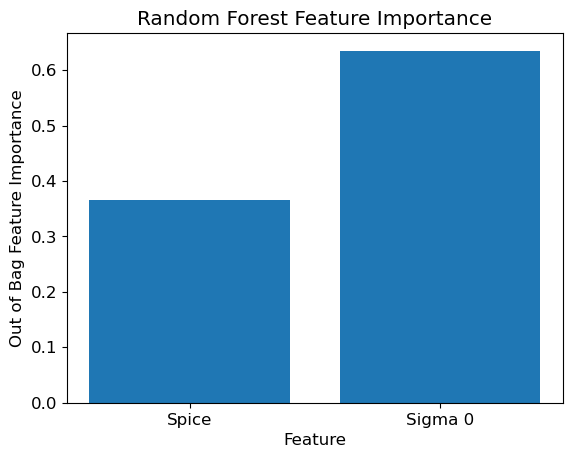

1.0


In [ ]:
Mdl_1.feature_importances_

plt.bar(var_list_1, Mdl_1.feature_importances_)
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Out of Bag Feature Importance")
plt.savefig("RFFeatureImportancepH.png")
plt.show()
print(sum(Mdl_1.feature_importances_))

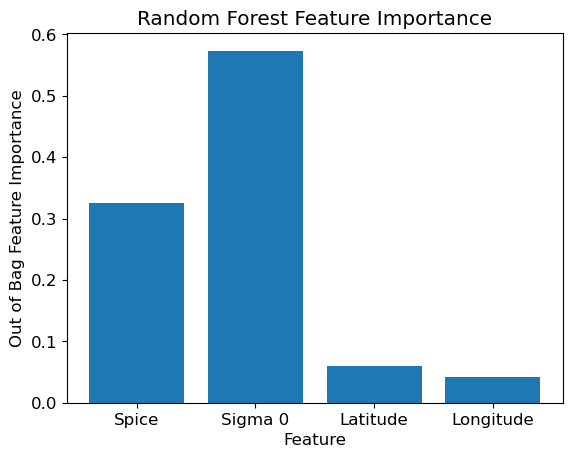

1.0000000000000002


In [ ]:
Mdl_2.feature_importances_

plt.bar(var_list_2, Mdl_2.feature_importances_)
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Out of Bag Feature Importance")
plt.savefig("RFFeatureImportancepH.png")
plt.show()
print(sum(Mdl_2.feature_importances_))

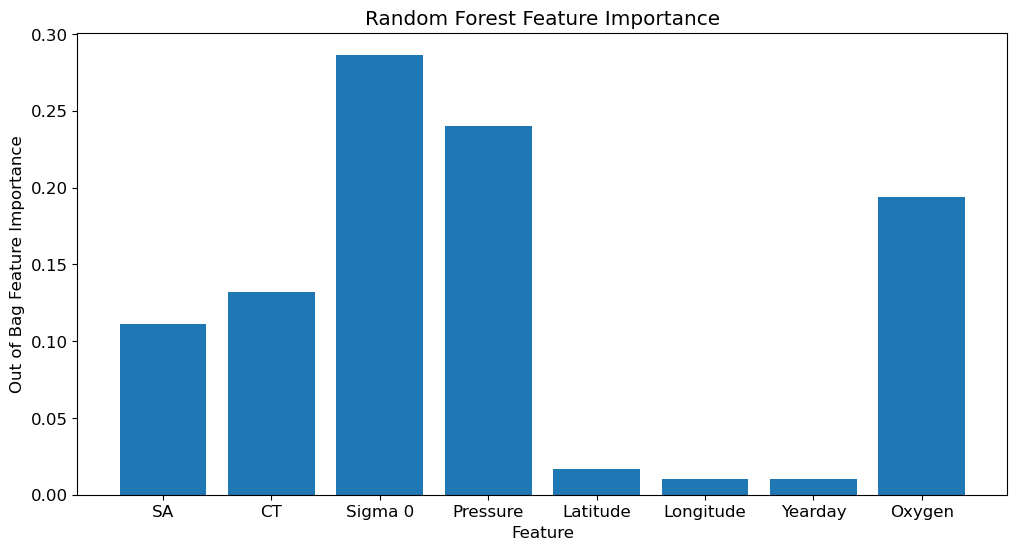

1.0


In [ ]:
Mdl_3.feature_importances_
plt.figure(figsize=(12,6))
plt.bar(var_list_3, Mdl_3.feature_importances_)
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Out of Bag Feature Importance")
plt.savefig("RFFeatureImportancepH.png")
plt.show()
print(sum(Mdl_3.feature_importances_))

In [ ]:
# Example of validation metrics for pH
# Can change to pH

validation_RF = validation
validation_RF["Predicted pH"] = Y_pred_validation
validation_RF["Error"] = Y_validation - Y_pred_validation
validation_RF["Relative Error"] = abs(validation_RF.Error.values) / Y_validation

# Split by depth and plot

validation_RF_DF = {
    "0-100": validation_RF[(validation_RF["Pressure"] >= 0) & (validation_RF["Pressure"] < 100)]["Error"].values,
    "100-200": validation_RF[(validation_RF["Pressure"] >= 100) & (validation_RF["Pressure"] < 200)]["Error"].values,
    "200-300": validation_RF[(validation_RF["Pressure"] >= 200) & (validation_RF["Pressure"] < 300)]["Error"].values,
    "300-400": validation_RF[(validation_RF["Pressure"] >= 300) & (validation_RF["Pressure"] < 400)]["Error"].values,
    "400-500": validation_RF[(validation_RF["Pressure"] >= 400) & (validation_RF["Pressure"] < 500)]["Error"].values,
    "500-600": validation_RF[(validation_RF["Pressure"] >= 500) & (validation_RF["Pressure"] < 600)]["Error"].values,
    "600-700": validation_RF[(validation_RF["Pressure"] >= 600) & (validation_RF["Pressure"] < 700)]["Error"].values,
    "700-800": validation_RF[(validation_RF["Pressure"] >= 700) & (validation_RF["Pressure"] < 800)]["Error"].values,
    "800-900": validation_RF[(validation_RF["Pressure"] >= 800) & (validation_RF["Pressure"] < 900)]["Error"].values,
    "900-1000": validation_RF[(validation_RF["Pressure"] >= 900) & (validation_RF["Pressure"] < 1000)]["Error"].values
}
dict1 = validation_RF_DF
labels, data = dict1.keys(), dict1.values()
plt.boxplot(data, vert = False, showfliers=False, widths=0.5)
plt.rcParams["figure.figsize"] = (5,5)
plt.title("pH Error Distribution RF")
plt.gca().invert_yaxis()
plt.yticks(range(1, len(labels) + 1), labels)
plt.ylabel("Depths (m)")
plt.xlabel("Error (actual - predicted)")
plt.xlim(-0.025, 0.025)
# plt.savefig("BoxPlotNitraateErrorRF100.png")

plt.show()


In [ ]:
# scores_rf = cross_val_score(Mdl_3,X_training,Y_training, scoring='accuracy', cv=10)
# print("Random Forest Mean:", scores_rf.mean(),"Standard Deviation:", scores_rf.std())

/Users/sangminsong/opt/anaconda3/envs/sogos_22/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sangminsong/opt/anaconda3/envs/sogos_22/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/sangminsong/opt/anaconda3/envs/sogos_22/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/sangminsong/opt/anaconda3/envs/sogos_22/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/sangminsong/opt/anaconda3/envs/sogos_22/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 211, 

Random Forest Mean: nan Standard Deviation: nan


/Users/sangminsong/opt/anaconda3/envs/sogos_22/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sangminsong/opt/anaconda3/envs/sogos_22/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/sangminsong/opt/anaconda3/envs/sogos_22/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/sangminsong/opt/anaconda3/envs/sogos_22/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/sangminsong/opt/anaconda3/envs/sogos_22/lib/python3.7/site-packages/sklearn/metrics/_classification.py", line 211, 

In [189]:
importlib.reload(sg)

<module 'sogos_module' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/CourseCode/MLGEO2022_sangsong/ml-sogos/scripts/sogos_module.py'>

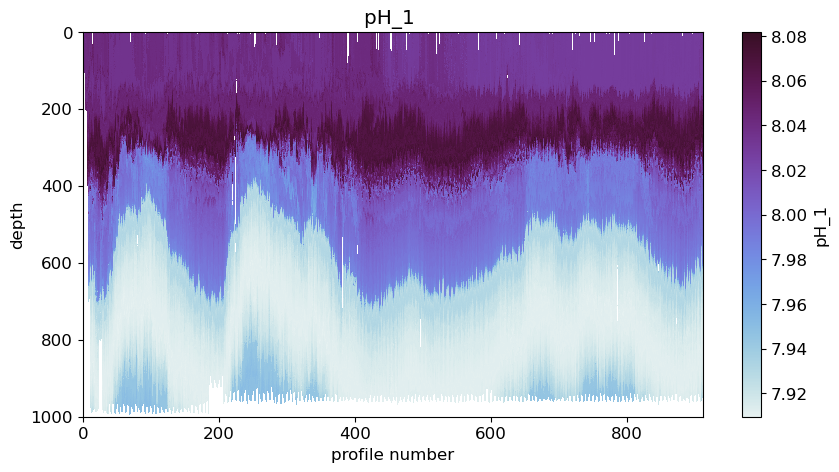

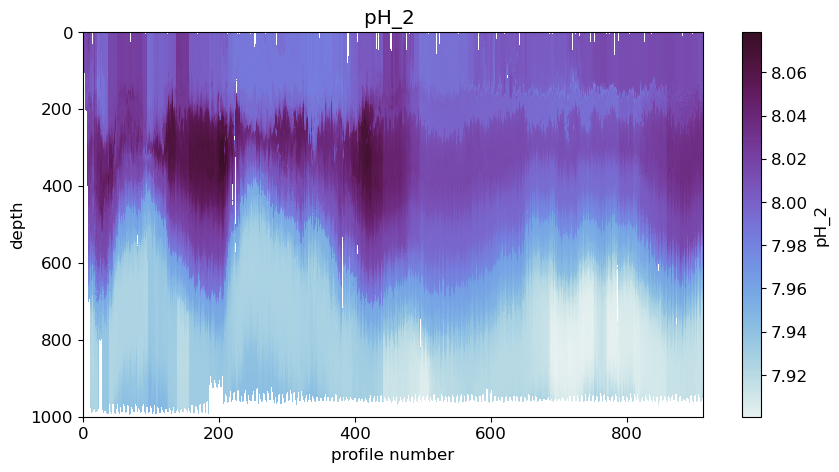

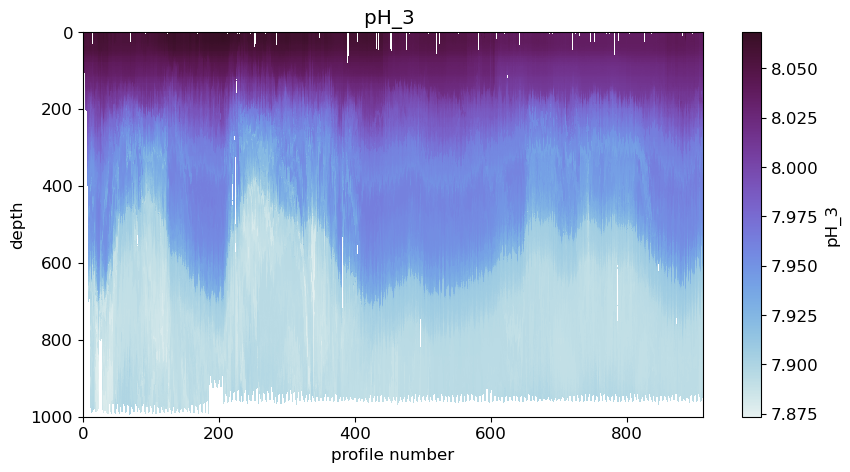

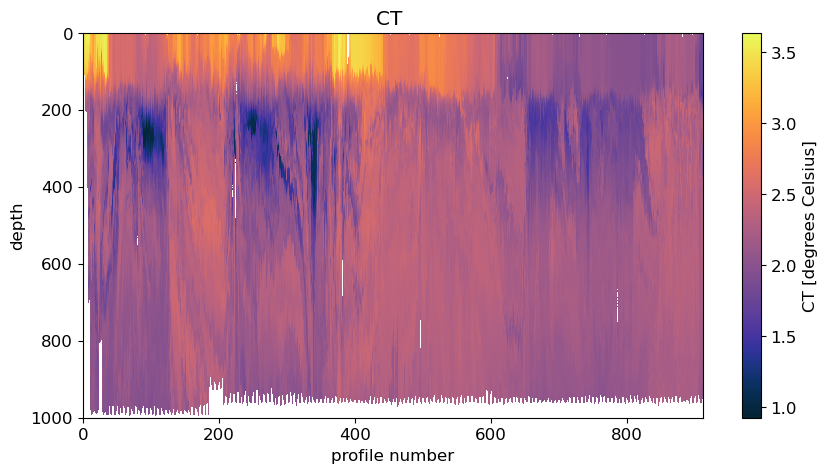

In [191]:
axes = sg.plotx_nprof(gp_659, vars = ['pH_1', 'pH_2', 'pH_3','CT'], tag='', save=False, lim=[])

Text(0.5, 1.0, 'glider 660 temperature')

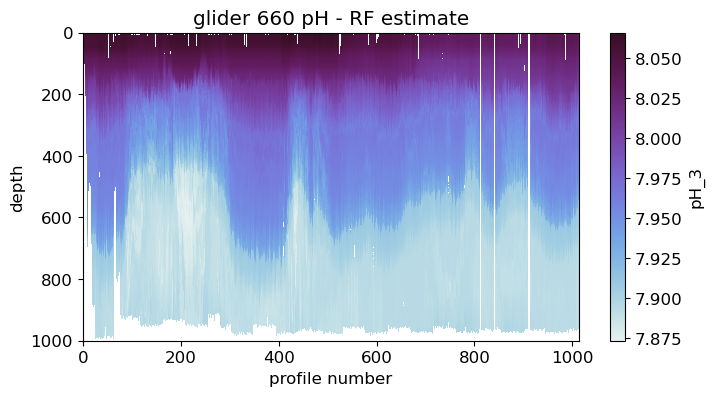

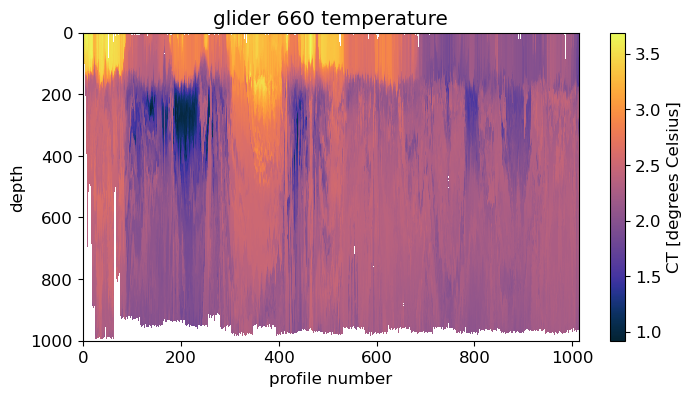

In [184]:
ax = sg.plot_var(gp_660, 'pH_3', cm=cmo.dense)
ax.set_title('glider 660 pH - RF estimate')
# sg.plot_var(gp_660, 'CT')
ax = sg.plot_var(gp_660, 'CT', cm=cmo.thermal)
ax.set_title('glider 660 temperature')


In [ ]:
# could plot difference metric over time
# for example, take average of models as mean, then plot sum of differences between each model and the mean over time
# are there periods of time in which the models have more inconsistencies between them? 


---
# Figures